In [1]:
import sys
from pathlib import Path
python_dir = Path("/Users/keisukemurota/Documents/todo/worms/python")
sys.path.insert(0, python_dir.resolve().as_posix())
import numpy as np 
from rmsKit import utils, lattice
import pandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

os.chdir(python_dir)

In [2]:
IMAGE_PATH = Path("visualize/image")
WORM_RESULT_PATH = python_dir / "rmsKit" / "array" / "quetta" 
MODEL_NAME = "HXYZ1D"
N = 10**6
BETA_THRES = 20
if not IMAGE_PATH.exists():
    raise FileNotFoundError("{} does not exist.".format(IMAGE_PATH.resolve()))
if not WORM_RESULT_PATH.exists():
    raise FileNotFoundError("{} does not exist.".format(WORM_RESULT_PATH.resolve()))

image_model_dir = IMAGE_PATH / MODEL_NAME
worm_result_path = WORM_RESULT_PATH / (MODEL_NAME+"_loc")

if not worm_result_path.exists():
    raise FileNotFoundError("{} does not exist.".format(worm_result_path.resolve()))


In [3]:
summary_files = utils.path.find_summary_files(worm_result_path)
df = utils.path.get_df_from_summary_files(summary_files, N)

In [105]:
import re
def extract_info_from_txt(file_path: Path):
    """Extract information from the given info.txt file."""
    best_loss_pattern = r"best loss: ([\d.e-]+)"
    initial_loss_pattern = r"initial loss: ([\d.e-]+)"
    hamiltonian_path_pattern = r"hamiltonian was saved to ([/\w._-]+)"
    unitary_path_pattern = r"best loss was saved to ([/\w._-]+)"

    # Read the file and extract information
    with open(file_path, 'r') as file:
        content = file.read()

        # Extract best loss
        best_loss_match = re.search(best_loss_pattern, content)
        best_loss = best_loss_match.group(1) if best_loss_match else None

        # Extract initial loss
        initial_loss_match = re.search(initial_loss_pattern, content)
        initial_loss = initial_loss_match.group(1) if initial_loss_match else None

        # Extract hamiltonian path
        hamiltonian_path_match = re.search(hamiltonian_path_pattern, content)
        hamiltonian_path = hamiltonian_path_match.group(1) if hamiltonian_path_match else None

        # Extract unitary path
        unitary_path_match = re.search(unitary_path_pattern, content)
        unitary_path = unitary_path_match.group(1) if unitary_path_match else None

    res = {
        "best_loss": float(best_loss),
        "initial_loss": float(initial_loss),
        "hamiltonian_path": Path(hamiltonian_path),
        "unitary_path": Path(unitary_path)
    }

    if None in res.values():
        raise ValueError("""
        Could not extract all required information from the given file.
        The file should contain the following information:
        - best loss
        - initial loss
        - hamiltonian path
        - unitary path
        The file content is:
        {}
        """.format(content))

    return res


In [158]:
def find_summary_files(directory_path):
    """Find all info.txt files under the given directory."""
    dir_path = Path(directory_path).resolve()
    if not dir_path.is_dir():
        raise ValueError(f"The given path {directory_path} is not a directory.")
    sim_res_folder = [path.parent for path in dir_path.rglob('summary/')]
    

    res = []
    for sim_res in sim_res_folder:
        
        summary_folder = sim_res / "summary"
        info_file = sim_res / "info.txt"
        assert summary_folder.is_dir()
        assert info_file.exists()
        for path in summary_folder.rglob('*.csv'):
            dic = dict()
            dic["summary"] = path
            dic["info"] = info_file
            res.append(dic)
    return res

import logging

def get_df_from_summary_files(summary_files: str, N: int):
    """Get a dataframe from the given summary files.

    summary files must be csv files.
    """
    df = None
    for res_dict in summary_files:
        sum_file = res_dict["summary"]
        info_file = res_dict["info"]
        info = extract_info_from_txt(info_file)
        if "sweeps_{}".format(N) in str(sum_file):
            try:
                df1 = pd.read_csv(sum_file)
                if not (df1.u_path.isnull().values.any()):
                    df1 = utils.get_loss(df1)
                    if np.abs(df1.loss.values - info["best_loss"]).mean() > 1E-6:
                        print(df1.loss, info["best_loss"])
                        raise ValueError("best_loss is not consistent with summary data")
            except BaseException as e:
                logging.warning("Could not concate or read {}".format(sum_file))
                logging.warning(e)

            df1["init_loss"] = info["initial_loss"]

            if df is not None:
                df = pd.concat([df, df1])
            else:
                df = df1

    df = df.reset_index(drop=True)
    return df


In [161]:
sum_res = find_summary_files(worm_result_path)
df = get_df_from_summary_files(sum_res, N)

In [162]:
print("looking for the result in {}".format(worm_result_path.resolve()))
print(worm_result_path.resolve())
df = df[df.sweeps == N]

df = df[df["T"] >= 1 / BETA_THRES]
print("temeprature simulated: {}".format(np.sort(df["T"].unique())))
print("L simulated: {}".format(np.sort(df.n_sites.unique())))

params_df = utils.param_dict_normalize(df['ham_path'].apply(utils.extract_parameters_from_path))
df_final = pd.concat([df, params_df], axis=1)
df_final = df_final.rename(columns = {"T":"temp"})

looking for the result in /Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/quetta/HXYZ1D_loc
/Users/keisukemurota/Documents/todo/worms/python/rmsKit/array/quetta/HXYZ1D_loc
temeprature simulated: [0.25 1.  ]
L simulated: [10 11 15]


In [163]:
df_final.temp.unique(), df_final.n_sites.unique()

(array([1.  , 0.25]), array([10, 11, 15]))

In [220]:
def filter_df(df, Jx, Jy, Jz, hx, hz):
    fil = df.Jx == Jx
    fil = fil & (df.Jy == Jy)
    fil = fil & (df.Jz == Jz)
    fil = fil & (df.hx == hx)
    fil = fil & (df.hz == hz)
    return df[fil]

In [221]:
df = df_final[(df_final.temp == T)&(df_final.n_sites == L)]
Jx_list = np.sort(df.Jx.unique())
Jy_list = np.sort(df.Jy.unique())
Jz_list = np.sort(df.Jz.unique())
hx_list = np.sort(df.hx.unique())
hz_list = np.sort(df.hz.unique())

df = filter_df(df, -1.8, -1.8, 1.0, 0, 0)

In [274]:
u = np.load("rmsKit/array/torch/HXYZ1D_loc/Jx_-2_Jy_-2_Jz_1_hx_0_hz_0/1_mel/Adam/lr_0.01_epoch_2000/loss_0.00000/u/0.npy")
H = np.load("rmsKit/array/quetta/HXYZ1D_loc/Jx_-1.8_Jy_-1.8_Jz_1_hx_0_hz_0/1_mel/H/0.npy")
U = np.kron(u,u)

h1 = utils.stoquastic(-U @ H @ U.T)
h2 = -H
L = 4
print(np.linalg.eigvalsh(utils.stoquastic(-U @ H @ U.T)), np.linalg.eigvalsh(-H))
H1 = utils.sum_ham(h1, [[i, (i+1)%L] for i in range(L)], L, 2)
H2 = utils.sum_ham(h2, [[i, (i+1)%L] for i in range(L)], L, 2)

np.linalg.eigvalsh(H2)

[-1.15  0.25  0.25  0.65] [-1.15  0.25  0.25  0.65]


array([-3.09422435e+00, -1.80000000e+00, -1.80000000e+00, -1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.88729700e-32,  3.76506735e-17,
        3.76506735e-17,  4.34853967e-16,  4.34853967e-16,  1.00000000e+00,
        1.00000000e+00,  1.80000000e+00,  1.80000000e+00,  2.09422435e+00])

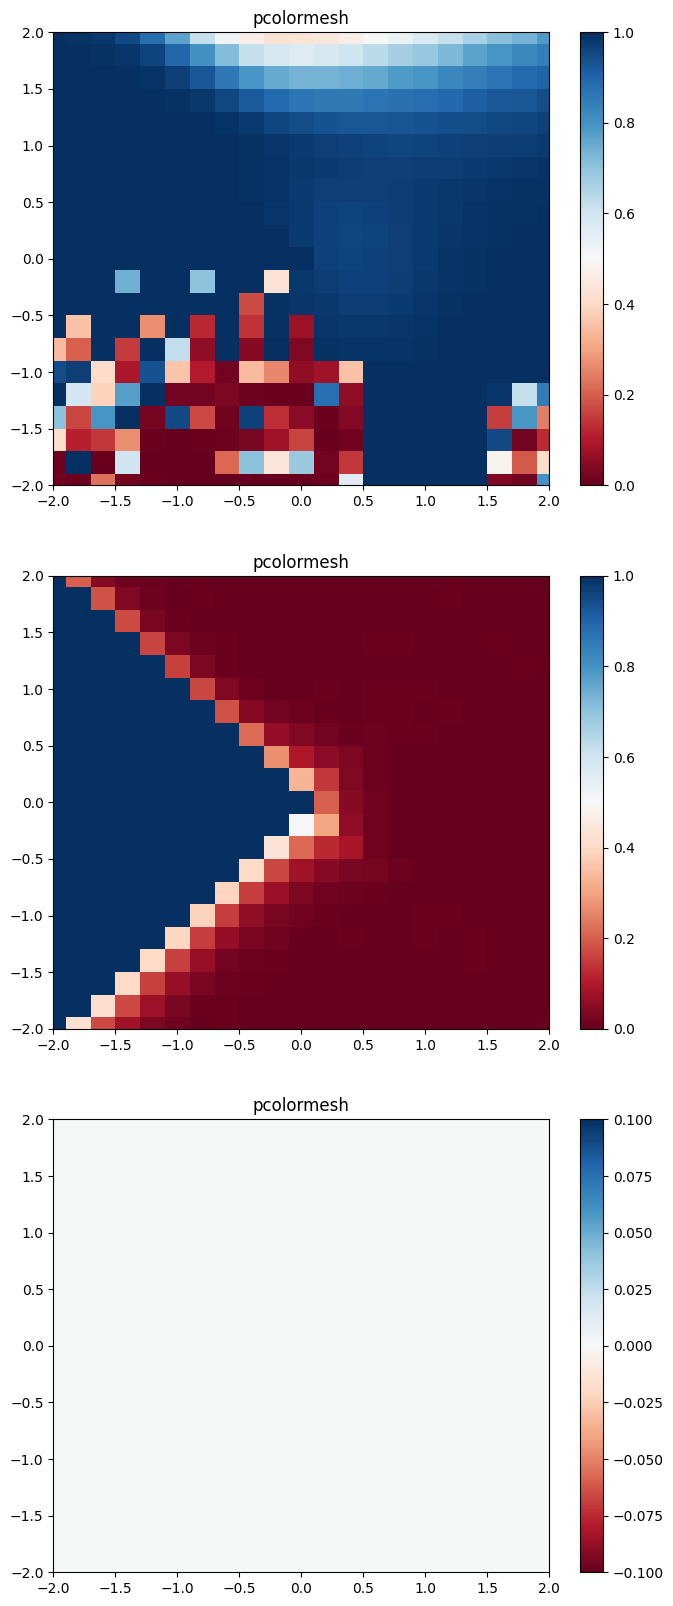

In [287]:
h = 0.5
T = 0.25
L = 11

df = df_final[(df_final.temp == T)&(df_final.n_sites == L)]

Jx_list = np.sort(df.Jx.unique())
Jy_list = np.sort(df.Jy.unique())
Jz_list = np.sort(df.Jz.unique())
hx_list = np.sort(df.hx.unique())
hz_list = np.sort(df.hz.unique())

z = []
z2 = []
z3 = []
df = df[df.hx == h]
x, y = np.meshgrid(Jx_list, Jy_list)
for Jx, Jy in zip(x.reshape(-1), y.reshape(-1)):
    df_plot = df[df.hx == h]
    df_plot = df_plot[(df_plot.Jx==Jx) & (df_plot.Jy==Jy)]
    df_u = df_plot[~df_plot.loss.isna()]
    df_h = df_plot[df_plot.loss.isna()]
#     au = df_u["as"].min()
    ah = df_h["as"].min()
    idx = np.argmin(df_u.loss.values)
    loss = df_u.loss.values[idx]
    init_loss = df_u.init_loss.values[idx]
    au = df_u["as"].values[idx]
    z3.append(loss)
    z.append(au)
    z2.append(ah)
Z = np.array(z).reshape(x.shape)
Z2 = np.array(z2).reshape(x.shape)
Z3 = np.array(z3).reshape(x.shape)

fig, ax = plt.subplots(3, 1,figsize=(8,20))

c = ax[0].pcolormesh(x, y, Z, cmap='RdBu', vmin=0, vmax=1)
ax[0].set_title('pcolormesh')
ax[0].axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax[0])

c = ax[1].pcolormesh(x, y, Z2, cmap='RdBu', vmin=0, vmax=1)
ax[1].set_title('pcolormesh')
ax[1].axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax[1])

c = ax[2].pcolormesh(x, y, Z3, cmap='RdBu', vmin=0, vmax=np.max(Z3))
ax[2].set_title('pcolormesh')
ax[2].axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax[2])


plt.show()

In [285]:
df_final.loss.unique()

array([ 0., nan])

In [224]:
df1 = df[df.Jx == df.Jy]
df2 = df1[df1["as"] != 1]